In [1]:
from matplotlib.pyplot import *
from astropy.cosmology import Planck18
import astropy.units as u
import tau
import ism
from copy import deepcopy
from baseband_analysis.core.bbdata import BBData
import os
import numpy as np
from chime_frb_api.backends import frb_master
master = frb_master.FRBMaster(base_url="https://frb.chimenet.ca/frb-master")
from baseband_analysis.pipelines.config import get_measured_parameter

%matplotlib widget
from tau import Burst

import importlib
import burst
import importlib
importlib.reload(tau)

import astropy.units as u

from matplotlib.pyplot import *
import plotting
import acf_tools

[2022-03-30 15:43:15,763] INFO Base URL: http://frb-vsop.chime:8001
[2022-03-30 15:43:15,765] INFO Version : 2021.12.0-alpha.7


Using hard-coded default config. Run update_from_site_config() toget config from kotekan


[2022-03-30 15:43:17,550] INFO Base URL: http://frb-vsop.chime:8001
[2022-03-30 15:43:17,552] INFO Version : 2021.12.0-alpha.7


In [2]:
importlib.reload(acf_tools)

[2022-03-30 15:43:17,570] INFO Base URL: http://frb-vsop.chime:8001
[2022-03-30 15:43:17,572] INFO Version : 2021.12.0-alpha.7


<module 'acf_tools' from '/home/calvin/Lensed-FRBs/acf_tools.py'>

# Quicklook
At all bursts from one source

/home/calvin/Lensed-FRBs/acf_tools.py:103: RuntimeWarning: invalid value encountered in sqrt
  (c ** 2 * (gamma + 1)) / (gamma ** 2 - c ** 2 * gamma ** 2 - c ** 2 * gamma)
/home/calvin/Lensed-FRBs/acf_tools.py:103: RuntimeWarning: invalid value encountered in sqrt
  (c ** 2 * (gamma + 1)) / (gamma ** 2 - c ** 2 * gamma ** 2 - c ** 2 * gamma)
/home/calvin/Lensed-FRBs/acf_tools.py:103: RuntimeWarning: invalid value encountered in sqrt
  (c ** 2 * (gamma + 1)) / (gamma ** 2 - c ** 2 * gamma ** 2 - c ** 2 * gamma)
/home/calvin/Lensed-FRBs/acf_tools.py:103: RuntimeWarning: invalid value encountered in sqrt
  (c ** 2 * (gamma + 1)) / (gamma ** 2 - c ** 2 * gamma ** 2 - c ** 2 * gamma)
/home/calvin/Lensed-FRBs/acf_tools.py:103: RuntimeWarning: invalid value encountered in sqrt
  (c ** 2 * (gamma + 1)) / (gamma ** 2 - c ** 2 * gamma ** 2 - c ** 2 * gamma)
/home/calvin/Lensed-FRBs/acf_tools.py:103: RuntimeWarning: invalid value encountered in sqrt
  (c ** 2 * (gamma + 1)) / (gamma ** 2 - c ** 2

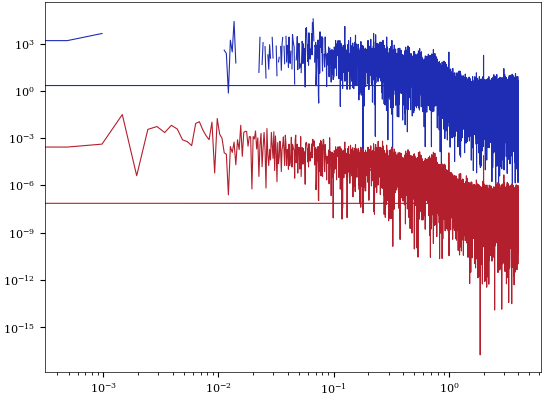

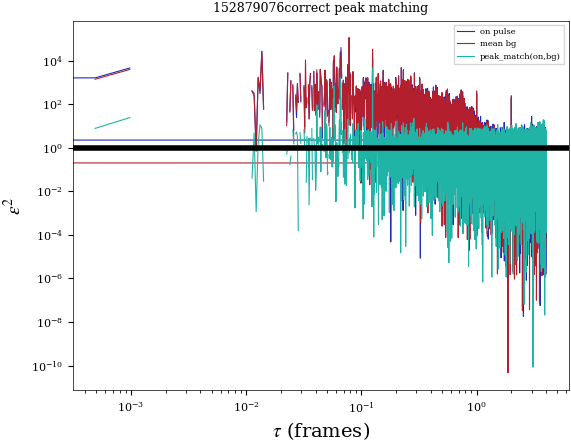

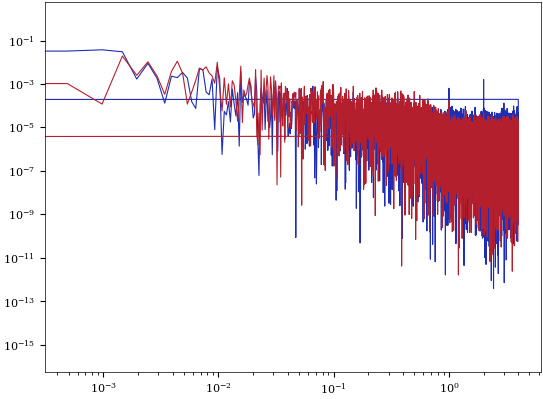

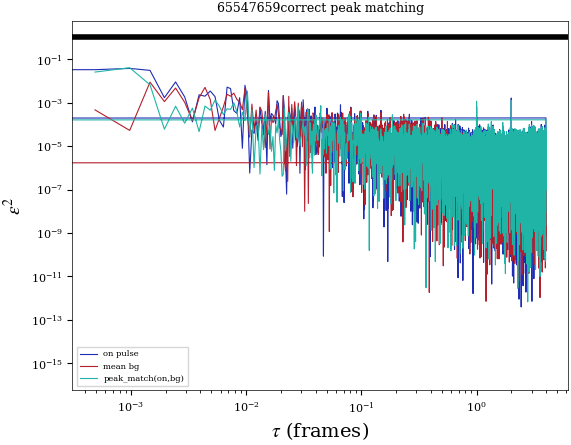

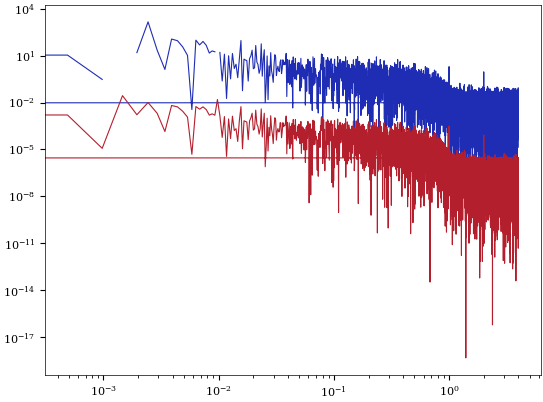

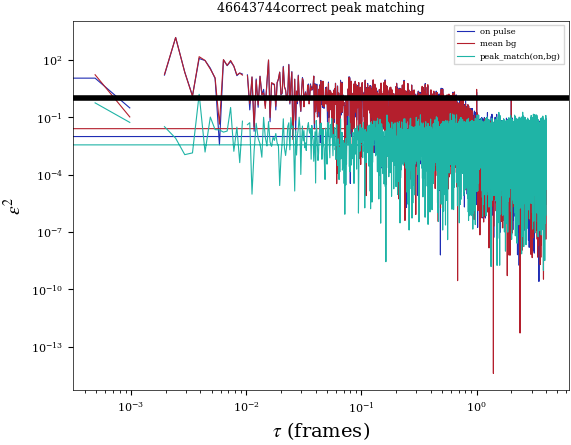

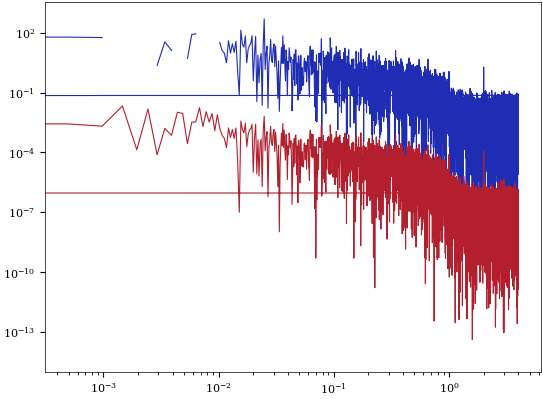

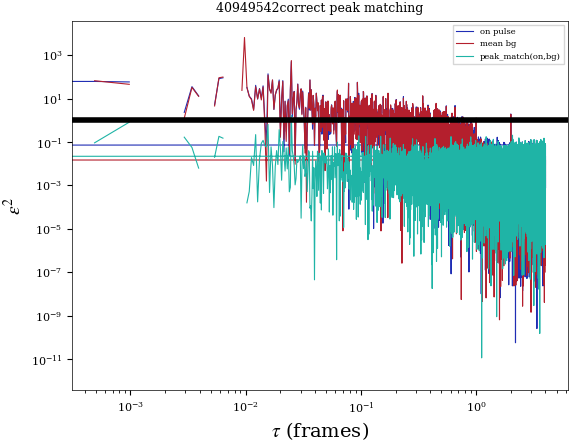

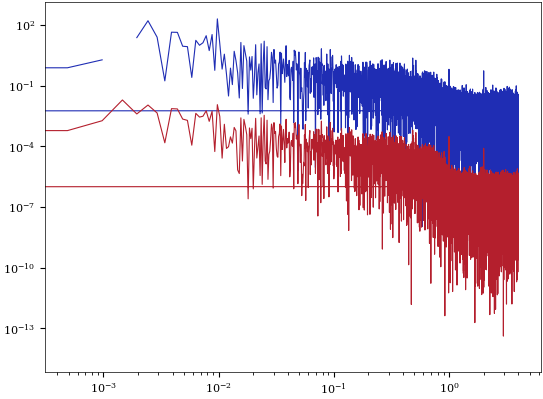

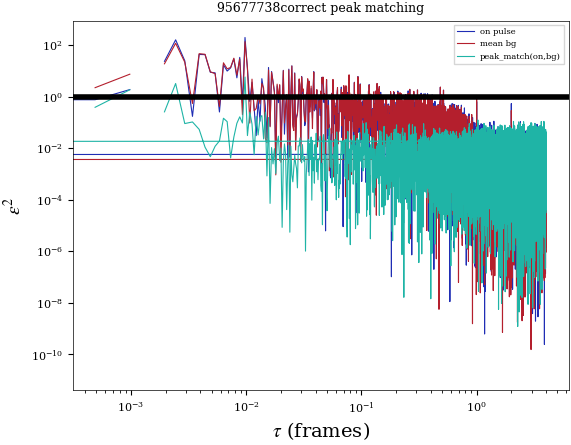

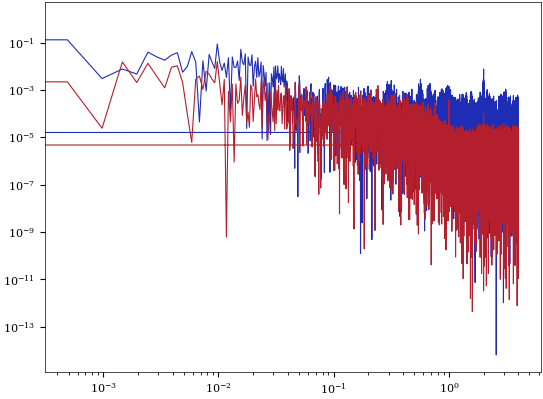

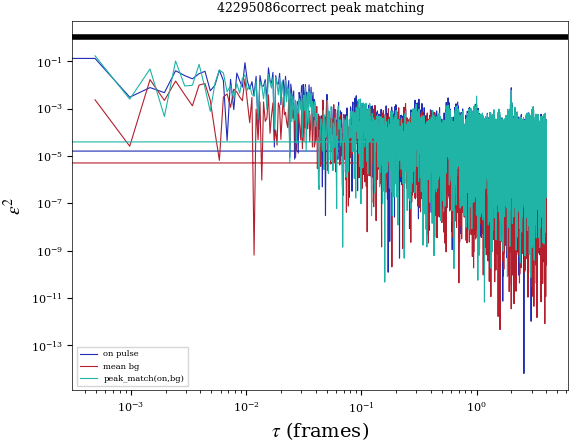

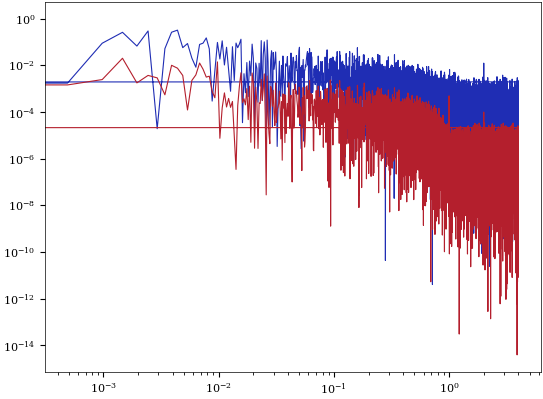

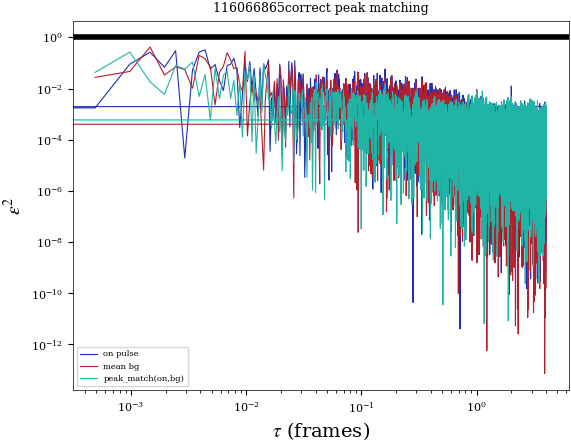

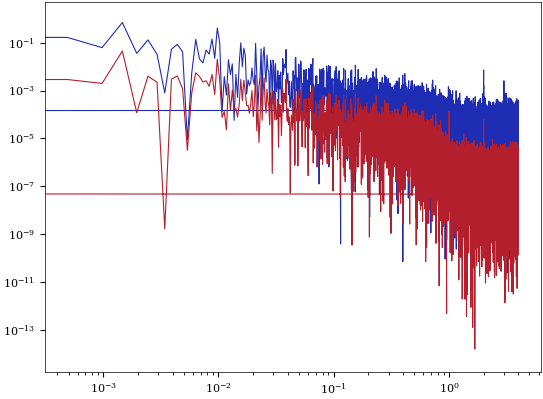

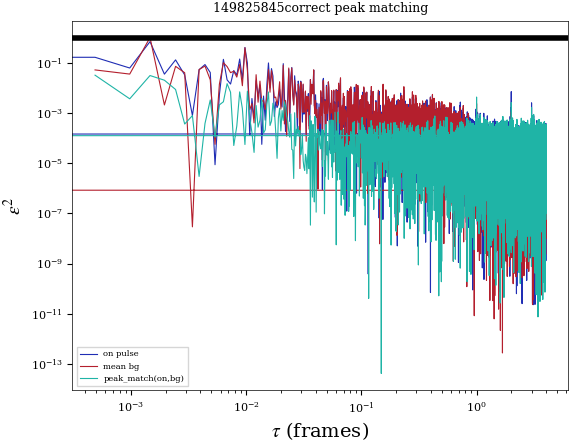

In [3]:
def peak_match_v7(e,fix = True):
    
    d = BBData.from_file(acf_tools.filename_from_event_id(e,version = 7))
    if fix:
        d["acf_lossless"][
                 :, 2, :
             ] /= 3  # there is a sum instead of a mean in the pipeline
             # the off-pulses are not in relmag units.
        d["acf_lossless"][
                 :, 3, :
             ] /= 3  # there is a sum instead of a mean in the pipeline
             # the off-pulses are not in relmag units.
        figure()
        loglog(d['lag_lossless'][:],d['acf_lossless'][0,0,:]**2,label = 'on pulse')
        loglog(d['lag_lossless'][:],d['acf_lossless'][0,2,:]**2,label = 'mean bg')
        

        d["acf_lossless"][:, 1, :] = acf_tools.corr_to_eps(
             corr=d["acf_lossless"][:, 1, :], 
             corr_lag=d["lag_lossless"][:],
             on_flux=d["Weighted Flux"]["On-Pulse"][:],
             off_flux=d["Weighted Flux"]["Off-Pulse"][:],
         )  # convert mock
        
        d["acf_lossless"][:, 2, :] = acf_tools.corr_to_eps(
             corr=d["acf_lossless"][:, 2, :], 
             corr_lag=d["lag_lossless"][:],
             on_flux=d["Weighted Flux"]["On-Pulse"][:],
             off_flux=d["Weighted Flux"]["Off-Pulse"][:],
         )  # convert mean of off pulses (used in peak match)
         # TODO: Change variance to relmag units too
    figure()
    loglog(d['lag_lossless'][:],d['acf_lossless'][0,0,:]**2,label = 'on pulse')
    loglog(d['lag_lossless'][:],d['acf_lossless'][0,2,:]**2,label = 'mean bg')
    loglog(d['lag_lossless'][:],(d['acf_lossless'][0,2,:] - d['acf_lossless'][0,0,:])**2,label = 'peak_match(on,bg)')
    axhline(1,color='black',linewidth=4)

    if fix:
        title(str(e) + 'correct peak matching')
    else:
        title(str(e) + 'wrong peak matching')
    legend()
    ylabel(r'$\varepsilon^2$',fontsize = 14)
    xlabel(r'$\tau$ (frames)',fontsize = 14)
    return

peak_match_v7(152879076)
peak_match_v7(65547659)
peak_match_v7(46643744)
peak_match_v7(40949542)
peak_match_v7(95677738)
peak_match_v7(42295086)
peak_match_v7(116066865)
peak_match_v7(149825845)

In [4]:
def compare_v7_v6(e):
    figure()
    for version in [6,7]:
        d = BBData.from_file(acf_tools.filename_from_event_id(e,version = version))
        l,eps = acf_tools.eps_vs_tau(d,iipol = 2,peak_match_short_lag = True,threshold = True,version=version) # combine polarizations, cut off values close to 0
        r = np.abs(eps)**2 # most values less than 1
        r = acf_tools.flag_bad_data(r,max_r = 1) # clip max values at 1.
        lag_mask = acf_tools.flag_integer_lags(l,max_n = 4) # flag integer lags
        r_inv = 1 / r[~lag_mask] # all values greater than 1, no integer lags
        loglog(l,r,label = f'data v{version}, eps_vs_tau(v{version})')
        title(e)
    legend()
    return l,r

#compare_v7_v6(152879076)
#compare_v7_v6(65547659)

# Define Lag and Mass Range

In [5]:
m_range = np.logspace(-6,5, num = 50)
lag_range = 1e-9 * np.logspace(0,8,num = 200)
global_bins_sec = np.hstack(
    (-np.geomspace(1e-9,1,num = 500)[::-1],[0],np.geomspace(1e-9,1,num = 500))) # 10 nanosecond cutoff


# Comparison of constant $R_f$ vs $R_f(\tau)$ 
For a single burst


In [6]:
from tau import geom_centers

In [7]:
from astropy.cosmology import Planck18

In [8]:
importlib.reload(acf_tools)

[2022-03-30 15:43:33,603] INFO Base URL: http://frb-vsop.chime:8001
[2022-03-30 15:43:33,605] INFO Version : 2021.12.0-alpha.7


<module 'acf_tools' from '/home/calvin/Lensed-FRBs/acf_tools.py'>

In [9]:
e = 65547659
r_f_constant = 4e-4
d = BBData.from_file(acf_tools.filename_from_event_id(e,version = 7))
l,eps = acf_tools.eps_vs_tau(d,iipol = 2,threshold = True,version = 7, 
                             peak_match_short_lag = True,
                             deripple = True) # combine polarizations, cut off values close to 0
r = np.abs(eps)**2 # square epsilon!
dm = eval(d.attrs['lens_pipeline'])['DM']
if dm is None:
    dm = get_measured_parameter(e)['dm']
dm_mw = acf_tools.get_dm_mw(e)
dm_eg = dm - dm_mw
z = tau.macquart(dm_eg,cosmo = Planck18, dm_host = 10**2.16)
print(f'dm = {dm:0.2f} - {dm_mw:0.2f} = {dm_eg:0.2f} -> macquart -> z ={z:0.3f}')         
lag_mask = acf_tools.flag_integer_lags(l,max_n = 4) 
tau_scatt = acf_tools.get_tau_scatt(e,sigmas = 2,tau_scatt_sec_default = 1e-4, tau_scatt_err_sec_default = 0)
r = acf_tools.flag_bad_data(r,max_r = 1) # all values less than 1 now
r_inv = 1 / r[~lag_mask] # all values greater than 1, no integer lags
# good data/ positive detection
frb_source = Burst(z_S = z, 
               r_f = r_inv, 
               lag = l[~lag_mask] * 2.56e-6,name = str(d.attrs['event_id']),
               tau_scatt = (tau_scatt) * u.s,
               dm = dm,
               dm_mw = dm_mw,
                  )
frb_source_const = Burst(z_S = z, 
               r_f = r_f_constant * np.ones(l[~lag_mask].shape), 
               lag = l[~lag_mask] * 2.56e-6,name = str(d.attrs['event_id']),
               tau_scatt = (tau_scatt) * u.s,
               dm = dm,
               dm_mw = dm_mw
                  )


/home/calvin/Lensed-FRBs/acf_tools.py:103: RuntimeWarning: invalid value encountered in sqrt
  (c ** 2 * (gamma + 1)) / (gamma ** 2 - c ** 2 * gamma ** 2 - c ** 2 * gamma)
[2022-03-30 15:43:33,678] INFO Authorization Status: None
[2022-03-30 15:43:33,679] INFO Authorization Method: Tokens
[2022-03-30 15:43:33,698] INFO Authorization Token : Expired
[2022-03-30 15:43:33,699] INFO Reauthorize Method: Tokens
[2022-03-30 15:43:33,732] INFO Authorization Expiry: Wed Mar 30 16:13:33 2022
[2022-03-30 15:43:33,733] INFO Reauthorize Result: Passed
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


dm = 464.56 - 49.39 = 415.16 -> macquart -> z =0.308


In [10]:
def plot_const_vs_variable(frb_source,frb_source_const,m_range,lag_range,r_f,figsize = plotting.prd_size(),
                           savefig=False):

    n_abcd_one_source = tau.dtau_dm([frb_source],
         m_range = m_range,
         lag_range = lag_range,
         min_rf = True,
         max_einstein_angle_global = np.inf,
         tau_scatt_global = 0 * u.s,
         d_sc_s = 1 * u.pc
         ).squeeze()   
    assert np.min(frb_source_const.r_f) == r_f

    n_abcd_one_source_const = tau.dtau_dm([frb_source_const],
         m_range = m_range,
         lag_range = lag_range,
         min_rf = True,
         max_einstein_angle_global = np.inf,
         tau_scatt_global = 0 * u.s,
         d_sc_s = 1 * u.pc
         ).squeeze()   

    f = figure(figsize=figsize)
    ax = f.add_axes([0.12, 0.11, 0.68, 0.78])
    ax.grid(False)
    f,ax = plotting.plot_dtau_dm_vs_lag_shaded(n_abcd_one_source,m_range,lag_range, draw_colorbar = False, fax = (f,ax))
    f,ax = plotting.plot_dtau_dm_vs_lag_shaded(n_abcd_one_source_const,m_range,lag_range, draw_colorbar = True, fax = (f,ax))
    ax.plot(geom_centers(m_range),0.001 + np.sum(n_abcd_one_source_const,axis = 0),
            color = 'black',lw = 1,
            linestyle = '--',label = r'$\varepsilon_{\rm min}^2 = 4\times 10^{-4}$')
    ax.plot(geom_centers(m_range),np.sum(n_abcd_one_source,axis = 0),
        color = 'black',lw = 1,
        label = r'$\varepsilon_{\rm min}^2 = \varepsilon_{\rm min}^2(\tau)$')

    ax.legend(bbox_to_anchor = [0.5, 0],loc = 'lower center',ncol = 1)
    ax.set_ylim([0,np.max(np.sum(n_abcd_one_source,axis = 0)) * 1.05])
    ax.set_xlim([np.min(geom_centers(m_range)),np.max(geom_centers(m_range))])
    #ax.set_title(r'$\lambda_{\tau i}$ for FRB 20191219F',fontsize = 10)
    ax.set_ylabel(r'$\lambda_{j}(M_c)$',fontsize = 10)

    if savefig:
        f.savefig(savefig,dpi=300)


Integrating 0/1
Using global value of max th_E=INF
Integrating 0/1
Using global value of max th_E=INF


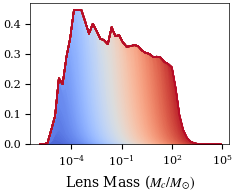

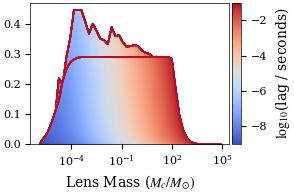

In [11]:
plot_const_vs_variable(frb_source,frb_source_const,m_range = m_range, lag_range = lag_range,
                       r_f = 4e-4,savefig='/home/calvin/Lensed-FRBs/plots/one_sightline.png')

# Deripple PFB Delay Space
F in the chat for our sub-optimal PFB inversion code

In [12]:
def plot_deripple_before_after(event_id,m_range,lag_range,peak_match = True,savefig=False):
    d = BBData.from_file(acf_tools.filename_from_event_id(event_id,version = 7))
    # get DM and z
    dm = eval(d.attrs['lens_pipeline'])['DM']
    if dm is None:
        dm = get_measured_parameter(e)['dm']
    dm_mw = acf_tools.get_dm_mw(e)
    dm_eg = dm - dm_mw
    z = tau.macquart(dm_eg,cosmo = Planck18, dm_host = 10**2.16)
    print(f'dm = {dm:0.2f} - {dm_mw:0.2f} = {dm_eg:0.2f} -> macquart -> z ={z:0.3f}')         
    
    # get epsilon from pipeline
    l,eps = acf_tools.eps_vs_tau(d,iipol = 2,threshold = True,version = 7, 
                                 peak_match_short_lag = peak_match,deripple=False) # combine polarizations, cut off values close to 0
    r = np.abs(eps)**2 # square epsilon!
    l,eps_derippled = acf_tools.eps_vs_tau(d,iipol = 2,threshold = True,version = 7, 
                                 peak_match_short_lag = peak_match,deripple=True) # combine polarizations, cut off values close to 0
    r_derippled = np.abs(eps_derippled)**2
    
    # compare epsilon
    figure()
    loglog(l,np.abs(eps_derippled)**2,label = 'after deripple')
    loglog(l,np.abs(eps)**2,label = 'before deripple')
    title(f"{event_id} (gamma = {d['Weighted Flux']['On-Pulse'][:] /d['Weighted Flux']['Off-Pulse'][:]})")
    legend()
    
    #
    lag_mask = acf_tools.flag_integer_lags(l,max_n = 4) 
    
    #
    tau_scatt = acf_tools.get_tau_scatt(e,sigmas = 2,tau_scatt_sec_default = 1e-4, tau_scatt_err_sec_default = 0)
    r = acf_tools.flag_bad_data(r,max_r = 1) # all values less than 1 now
    r_inv = 1 / r[~lag_mask] # all values greater than 1, no integer lags
    # good data/ positive detection
    frb_source = Burst(z_S = z, 
                   r_f = r_inv, 
                   lag = l[~lag_mask] * 2.56e-6,name = str(d.attrs['event_id']),
                   tau_scatt = (tau_scatt) * u.s,
                   dm = dm,
                   dm_mw = dm_mw,
                      )
    
    r_derippled = acf_tools.flag_bad_data(r_derippled,max_r = 1) # all values less than 1 now
    r_inv_derippled = 1 / r_derippled[~lag_mask]
    
    frb_source_derippled = Burst(z_S = z, 
                   r_f = r_inv_derippled, 
                   lag = l[~lag_mask] * 2.56e-6,name = str(d.attrs['event_id']),
                   tau_scatt = (tau_scatt) * u.s,
                   dm = dm,
                   dm_mw = dm_mw,
                      )
    
    
#plot_deripple_before_after(event_id = 65547659,m_range = m_range,lag_range = lag_range,savefig=False,peak_match = True)
#plot_deripple_before_after(event_id = 65547659,m_range = m_range,lag_range = lag_range,savefig=False,peak_match = False)

#plot_deripple_before_after(event_id = 152879076,m_range = m_range,lag_range = lag_range,savefig=False)
#plot_deripple_before_after(152879076,m_range = m_range, lag_range = lag_range, savefig = False)
#plot_deripple_before_after(65547659,m_range = m_range, lag_range = lag_range, savefig = False)
#plot_deripple_before_after(46643744,m_range = m_range, lag_range = lag_range, savefig = False)
#plot_deripple_before_after(40949542,m_range = m_range, lag_range = lag_range, savefig = False)
#plot_deripple_before_after(95677738,m_range = m_range, lag_range = lag_range, savefig = False)
#plot_deripple_before_after(42295086,m_range = m_range, lag_range = lag_range, savefig = False)
#plot_deripple_before_after(116066865,m_range = m_range, lag_range = lag_range, savefig = False)
#plot_deripple_before_after(149825845,m_range = m_range, lag_range = lag_range, savefig = False)

# Single Burst Lag Bin Interpolation
Test that the interpolation works pretty well, by using one burst.


In [13]:
global_bins_sec

array([-1.        , -0.95932095, -0.92029668, ...,  0.92029668,
        0.95932095,  1.        ])

In [14]:
def plot_interpolate_before_after(m_range,lag_range,frb_source,global_bins_sec,diagnostic=True,savefig=False,figsize = plotting.prd_size()):
    n_ac_one_source = tau.dtau_dm([frb_source],
         m_range = m_range,
         lag_range = lag_range,
         min_rf = True,
         max_einstein_angle_global = np.inf,
         tau_scatt_global = 0 * u.s,
         d_sc_s = 1 * u.pc
         ).squeeze()   

    frb_source.interpolate_r_f(global_bins_sec)

    n_ac_one_source_after = tau.dtau_dm([frb_source],
         m_range = m_range,
         lag_range = lag_range,
         min_rf = True,
         max_einstein_angle_global = np.inf,
         tau_scatt_global = 0 * u.s,
         d_sc_s = 1 * u.pc
         ).squeeze()   
    overestimate = np.sum(n_ac_one_source,axis = 0) - np.sum(n_ac_one_source_after,axis = 0)
    print('Private data is better by :',np.max(overestimate))
    f = figure(figsize=figsize)
    ax = f.add_axes([0.12, 0.11, 0.68, 0.78])
    ax.grid(False)
    plotting.plot_dtau_dm_vs_lag_shaded(n_ac_one_source,m_range,lag_range, draw_colorbar = False, fax = (f,ax))
    plotting.plot_dtau_dm_vs_lag_shaded(n_ac_one_source_after,m_range,lag_range, draw_colorbar = True, fax = (f,ax))
    ax.set_xscale('log')
    ax.plot(geom_centers(m_range),np.sum(n_ac_one_source,axis = 0),
            color = 'black',lw = 1,
            label = r'No Interpolation')
    ax.plot(geom_centers(m_range),0.001 + np.sum(n_ac_one_source_after,axis = 0),
            color = 'black',lw = 1,
            linestyle = '--',label = r'Interpolated')
    ax.legend(bbox_to_anchor = [0.5, 0],loc = 'lower center',ncol = 2)
    ax.set_ylim([0,0.35])
    ax.set_title(r'$\lambda_{ij}$ for FRB 20191219F',fontsize = 10)

    if savefig:
        f.savefig(savefig,dpi = 300)
    if diagnostic:
        figure()
        plot(geom_centers(m_range),np.sum(n_ac_one_source,axis = 0) - np.sum(n_ac_one_source_after,axis = 0))
        xscale('log')

Integrating 0/1
Using global value of max th_E=INF
Integrating 0/1
Using global value of max th_E=INF
Private data is better by : 0.18221224304555955


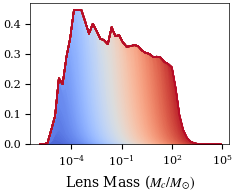

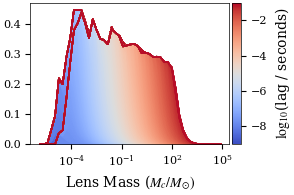

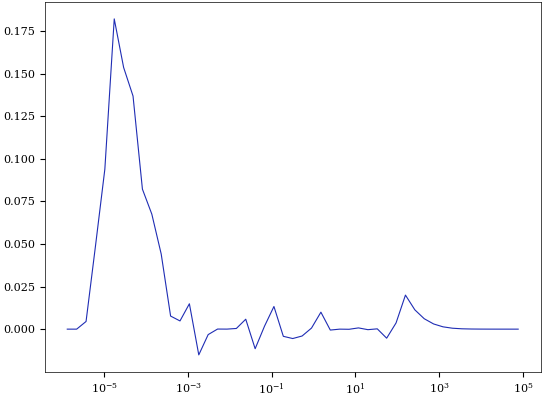

In [15]:
plot_interpolate_before_after(m_range,lag_range,frb_source,global_bins_sec,diagnostic=True,
                              savefig=False #'/home/calvin/Lensed-FRBs/plots/interpolation.png
                             )


# MW vs HG Comparison

In [16]:
# Compute optical depth integrals
def plot_mw_vs_host(frb_source,m_range,lag_range,d_sc_s = 1,figsize = plotting.prd_size(),savefig=False):
    n_ac_one_source_host = tau.dtau_dm([frb_source],
         m_range = m_range,
         lag_range = lag_range,
         min_rf = True,
         max_einstein_angle_global = None,
         tau_scatt_global = np.inf * u.s,
         d_sc_s = d_sc_s * u.pc,
         screen = 'hg',
         alpha_s = 0.5,
         alpha_l = -1,
         ).squeeze()   
    n_ac_one_source_mw = tau.dtau_dm([frb_source],
         m_range = m_range,
         lag_range = lag_range,
         min_rf = True,
         max_einstein_angle_global = None,
         tau_scatt_global = np.inf * u.s,
         d_sc_s = d_sc_s * u.pc,
         screen = 'mw',
         alpha_s = 0.5,
         alpha_l = -1,
         ).squeeze()   

    f = figure(figsize= figsize)
    ax = f.add_axes([0.12, 0.11, 0.68, 0.78])
    ax.grid(False)
    plotting.plot_dtau_dm_vs_lag_shaded(n_ac_one_source_host,m_range,lag_range, draw_colorbar = False, fax = (f,ax))
    plotting.plot_dtau_dm_vs_lag_shaded(n_ac_one_source_mw,m_range,lag_range, draw_colorbar = False, fax = (f,ax))
    print('Max diff (hg - mw):',np.max(np.abs(n_ac_one_source_host - n_ac_one_source_mw)))
    if savefig:
        f.savefig(savefig)


# Flat vs curved spacetime comparison
Use HG screen

In [17]:
# Compute optical depth integrals
def plot_flat_vs_curved(frb_source,m_range,lag_range,d_sc_s = 1,alpha_l = -1,alpha_s = 0.5,
                        figsize = plotting.prd_size(),savefig=False,diagnostic=True):

    n_ac_one_source_host_flat = tau.dtau_dm([frb_source],
         m_range = m_range,
         lag_range = lag_range,
         min_rf = True,
         max_einstein_angle_global = None,
         tau_scatt_global = np.inf * u.s,
         d_sc_s = 1 * u.pc,
         screen = 'hg',
         alpha_s = 0,
         alpha_l = 0,
         ).squeeze()  

    # Compute optical depth integrals
    n_ac_one_source_host_curved = tau.dtau_dm([frb_source],
         m_range = m_range,
         lag_range = lag_range,
         min_rf = True,
         max_einstein_angle_global = None,
         tau_scatt_global = np.inf * u.s,
         d_sc_s = 1 * u.pc,
         screen = 'hg',
         alpha_s = 0.5,
         alpha_l = -1,
         ).squeeze()   
    print('Max diff (flat - curved):',np.max(np.abs(n_ac_one_source_host_flat - n_ac_one_source_host_curved)))
    f = figure(figsize=figsize)
    ax = f.add_axes([0.12, 0.11, 0.68, 0.78])
    ax.grid(False)
    f,ax = plotting.plot_dtau_dm_vs_lag_shaded(n_ac_one_source_host_curved,m_range,lag_range, draw_colorbar = False, fax = (f,ax))
    f,ax = plotting.plot_dtau_dm_vs_lag_shaded(n_ac_one_source_host_flat,m_range,lag_range, draw_colorbar = False, fax = (f,ax))
    if savefig:
        f.savefig(savefig)
    if diagnostic:
        # 1: plot total and zoom in
        figure()
        semilogx(geom_centers(m_range),np.sum(n_ac_one_source_host_curved,axis = 0),label = 'curved')
        semilogx(geom_centers(m_range),np.sum(n_ac_one_source_host_flat,axis = 0),label = 'flat')
        legend()
        ylabel(r'$\lambda_{j}$')
        xlabel(r'$M/M_\odot$')
        # 2: plot 1+z factors
        figure()
        for z_S in [0.2,0.4,0.6,0.8,1.0]:
            z_L = np.linspace(0,z_S)
            fill_between(z_L,y1 = 0, y2 = (1+z_S)**0.5 / (1+z_L),alpha = 0.2,label = z_S)
            plot(z_L, np.mean((1+z_S)**alpha_s * (1+z_L)**alpha_l) + np.zeros(z_L.shape))
            xlabel(r'$z_L$')
            ylabel(r'$\sqrt{1+z_S} / (1+z_L)$')
        legend()

Integrating 0/1
Integrating 0/1


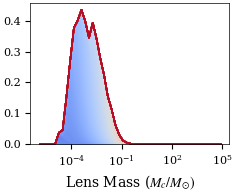

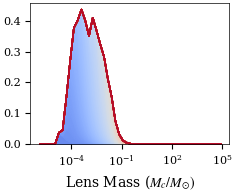

Max diff (hg - mw): 0.006130805520641181
Integrating 0/1
Integrating 0/1
Max diff (flat - curved): 0.0012277194626702306


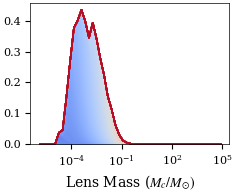

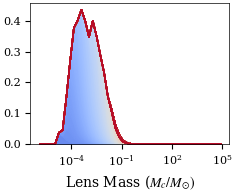

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


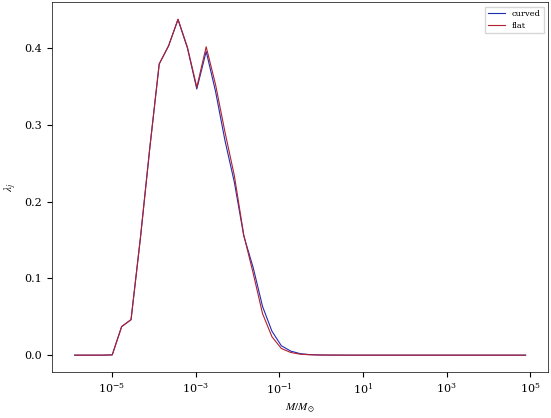

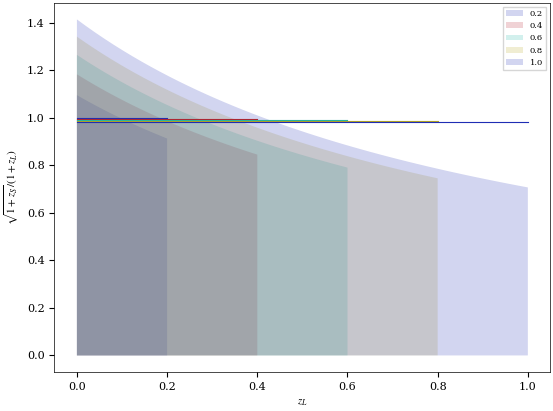

In [18]:
plot_mw_vs_host(frb_source,m_range = m_range, lag_range = lag_range,savefig=False)
plot_flat_vs_curved(frb_source,m_range,lag_range,d_sc_s = 1,savefig=False)


# Search V4 Ungrouped Event IDs
This is a dictionary of unique sightlines, each of which is a list of repeating FRBs. Zarif has a script to produce this which I don't fully understand but which I trust works. I have identified from the Wiki the relevant repeater IDs.

In [19]:
from astropy.cosmology import Planck18

In [20]:
Planck18

FlatLambdaCDM(name="Planck18", H0=67.7 km / (Mpc s), Om0=0.31, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.049)

In [21]:
# equivalent information here:
v4_event_ids = {'?': {83518494, 112839966, 46643744, 40949542, 95677738, 42295086, 116066865, 149825845, 137628984, 152062271, 83390274, 133632325, 157646917, 33769804, 37696333, 60792403, 100997459, 140538715, 60955229, 95822946, 27687783, 163213672, 86099817, 66294123, 164389739, 84633456, 86321776, 25677682, 164240257, 140464005, 138368391, 65547659, 58983056, 143498385, 140210071, 161700760, 37129627, 82793120, 113599905, 138244000, 44290216, 42809769, 27052203, 83036587, 94585529, 66073531, 145086396, 45371331, 81110473, 59794378, 82942418, 137003986, 140655323, 72662238, 38440671, 152879076, 82864103, 32158184, 156410110, 81192703}, 'R29': {31644043, 68252213}, 'R17': {62352548, 59240332, 156691863, 114118424, 157073977, 66995325}, 'R51': {69541452, 145207799}, 'R4': {69841193, 69978377}, 'R68=R74': {145654275, 144722364}, 'R71': {148980870, 149540279}, 'R70': {152187528, 150850977, 152716207}}
v6_event_ids = {'?': {83518494, 112839966, 46643744, 172924963, 40949542, 95677738, 42295086, 116066865, 149825845, 137628984, 152062271, 83390274, 133632325, 157646917, 33769804, 135866445, 37696333, 60792403, 100997459, 140538715, 60955229, 95822946, 27687783, 163213672, 86099817, 66294123, 164389739, 84633456, 173588081, 86321776, 25677682, 82758778, 41208961, 164240257, 140464005, 138368391, 65547659, 58983056, 143498385, 140210071, 161700760, 83744922, 32328347, 135856796, 37129627, 82793120, 171808929, 113599905, 138244000, 44290216, 42809769, 27052203, 83036587, 29204654, 60678575, 94585529, 66073531, 145086396, 45371331, 81110473, 59794378, 90015951, 135259857, 82942418, 137003986, 60569049, 140655323, 43354078, 72662238, 38440671, 152879076, 82864103, 82874344, 32158184, 100846839, 156410110, 81192703}, 'R15': {41866365}, 'R2': {42435604}, 'R24': {59560503}, 'R17': {62352548, 163100809, 94672522, 59240332, 133646258, 65049940, 156691863, 114118424, 157073977, 66995325, 68602622}, 'R3': {71784833, 69509443, 65511496, 92773515, 153859596, 59993356, 71785167, 83984528, 67522832, 71784400, 84081108, 71665813, 180666196, 163181014, 92844954, 155079679, 154910364, 171855709, 154913824, 175004577, 171681248, 151677988, 163362088, 176060009, 163534005, 175929272, 166812476, 180667327}, 'R4': {69848452, 69978377, 69975256, 69841193, 69975309}, 'R12': {155679530, 70375108, 173825813, 84032182}, 'R35': {70836867, 73676317}, 'R32': {71834323}, 'R30': {72197704}, 'R33': {72987796}, 'RN3': {152623236, 148108132, 73804471}, 'R43': {86092282, 60100515}, 'R47': {95416492, 97646351}, 'R50': {96534808}, 'R14': {158514696, 167591075, 104638972}, 'R6': {145781585}, 'R70': {150850977, 148957878, 152187528, 162566473, 152716207}, 'R49': {152308061}, 'R54': {155646493}, 'R68=R76': {164885944, 165956452, 165001685, 174906271}, 'R67': {172176403, 166462644, 166030118, 166990141, 166462622, 166462575}, 'R51': {168743856, 145207799, 169669688, 168930553, 69541452}, 'R77': {172091258}, 'R80': {173616504, 180108339}, 'R55': {41252817}, 'R52': {43822123}, 'R37': {61706633}, 'R26': {61876054}, 'R40': {61913156}, 'R16': {65982134}, 'C20': {68600370}, 'R48=R79': {69246471}, 'C21': {71042240}, 'C2': {71571699}, 'R41': {84271986}, 'R44': {93628004}, 'R59': {135521375}, 'R64': {138618955}, 'C56': {145838592}, 'R72': {150709160}, 'C30': {153287440}, 'R78': {157073938}, 'C79': {157363005}, 'R75': {162792037}, 'R29': {31644043, 68252213}, 'R68=R74': {145654275, 144722364}, 'R71': {148980870, 149540279}}
v7_event_ids = v6_event_ids

#for v in v6_event_ids['?']:
#    if v not in event_ids: 
#        print(v)#,get_measured_parameter(v)['dm']) # all are crab pulses or 138244000

In [22]:
R3_only = {'R3': {71784833, 69509443, 65511496, 92773515, 153859596, 59993356, 71785167, 83984528, 67522832, 71784400, 84081108, 71665813, 180666196, 163181014, 92844954, 155079679, 154910364, 171855709, 154913824, 175004577, 171681248, 151677988, 163362088, 176060009, 163534005, 175929272, 166812476, 180667327}}

In [23]:
def z_from_DM(e,d):
    dm = eval(d.attrs['lens_pipeline'])['DM']
    if dm is None:
        dm = get_measured_parameter(e)['dm']
    dm_mw = acf_tools.get_dm_mw(e)
    dm_eg = dm - dm_mw - 50 # Halo contribution
    z = tau.macquart(dm_eg,cosmo = Planck18, dm_host = 117) # 10**2.16 from best fit in James et al 2021
    print(f'dm = {dm:0.2f} - {dm_mw:0.2f} = {dm_eg:0.2f} -> macquart -> z ={z:0.3f}')  
    
    if dm > 5000:
        print('This is a 190520-like source!')
        z = tau.macquart(dm_eg,cosmo = Planck18, dm_host = 117 * 2) # This is a 121102-like source
        print(f'dm = {dm:0.2f} - {dm_mw:0.2f} = {dm_eg:0.2f} -> macquart + 900 DM host -> z ={z:0.3f}')         
    if e == 172924963: # localized!
        print('This is localized')
        z = 0.18
    return z,dm,dm_mw

In [24]:
importlib.reload(acf_tools)

[2022-03-30 15:52:07,984] INFO Base URL: http://frb-vsop.chime:8001
[2022-03-30 15:52:07,985] INFO Version : 2021.12.0-alpha.7


<module 'acf_tools' from '/home/calvin/Lensed-FRBs/acf_tools.py'>

In [61]:
all_sightlines = []
unconverted = True
table_for_paper_header = ['event_id','fitburst SNR','DM','DM_mw','tau_scatt']
table_for_paper = []
all_n = []
for rname in v6_event_ids.keys():
    sightline = v6_event_ids[rname]
    sightline_ordered = list(sightline)
    sightline_ordered.sort(key = lambda x: acf_tools.get_fitburst_snr(x))
    sightline_bursts = []
    print(f'Looking at bursts from {rname}')
    for e in sightline_ordered:
        try:
            d = BBData.from_file(acf_tools.filename_from_event_id(e,version = 7))
            #pipeline_attributes = eval(d.attrs['lens_pipeline'])
            query_result = master.events.get_event(e) # check that 
            if query_result['event_type'] == 'KNOWN-PULSAR' or query_result['event_type'] == 'GALACTIC-SOURCE':
                print(f'Omitting event {e} for being a known pulsar etc.')
            if query_result['event_type'] != 'KNOWN-PULSAR' and query_result['event_type'] != 'GALACTIC-SOURCE':
                print(f'Including event {e} in constraints')
                l,eps = acf_tools.eps_vs_tau(d,iipol = 2,threshold = True,version=7,
                                             peak_match_short_lag = True,deripple=True) # combine polarizations, cut off values close to 0
                r = np.abs(eps)**2 # most values less than 1
                r = acf_tools.flag_bad_data(r,max_r = 1) # clip max values at 1.
                lag_mask = acf_tools.flag_integer_lags(l,max_n = 4) # flag integer lags
                r_inv = 1 / r[~lag_mask] # all values greater than 1, no integer lags
                
                tau_scatt = acf_tools.get_tau_scatt(e,
                                          sigmas = 2,
                                          tau_scatt_sec_default = 1e-4, 
                                          tau_scatt_err_sec_default = 0)
                z,dm,dm_mw = z_from_DM(e,d)
                frb_source = Burst(z_S = z, 
                                   r_f =r_inv, 
                                   lag = l[~lag_mask] * 2.56e-6,
                                   name = str(d.attrs['event_id']),
                                   tau_scatt = (tau_scatt) * u.s,
                                   dm = dm,
                                   dm_mw = dm_mw

                                      )
                assert not np.isnan(frb_source.get_r_f(lag_range[1:])).any(), f'event {e} has nans!'
                frb_source.interpolate_r_f(lag_bins = global_bins_sec) # interpolate lag range to something globally consistent
                frb_source.save_to_h5(filename = f'/data/user-data/calvin/lens_search_v7/public/{e}.h5')
                sightline_bursts.append(frb_source)
                table_for_paper.append([e,acf_tools.get_fitburst_snr(e),dm,dm_mw,tau_scatt])
        except OSError:
            UserWarning(f'{e} FAILED! No data found')
            pass
    # did more than zero bursts from this sightline succeeed?
    if len(sightline_bursts) > 0 and rname != '?': # include all non-r's, indicated by "?", and brightest repeats
        all_sightlines.append(sightline_bursts[-1])
        print(f'Adding {sightline_bursts[-1].name}')
    if len(sightline_bursts) > 0 and rname == '?': # add all non-r's
        all_sightlines = all_sightlines + sightline_bursts
        print(f'Adding {[b.name for b in sightline_bursts]}')

Looking at bursts from ?
Including event 145086396 in constraints


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide


dm = 157.88 - 38.31 = 69.57 -> macquart -> z =0.003
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/145086396.h5
Including event 59794378 in constraints
dm = 249.13 - 84.24 = 114.89 -> macquart -> z =0.003
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/59794378.h5
Including event 152879076 in constraints
dm = 440.43 - 29.48 = 360.96 -> macquart -> z =0.273
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/152879076.h5
Including event 46643744 in constraints
dm = 716.07 - 36.72 = 629.34 -> macquart -> z =0.543
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/46643744.h5
Including event 82874344 in constraints
dm = 674.19 - 50.69 = 573.50 -> macquart -> z =0.488
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/82874344.h5
Including event 41208961 in constraints
dm = 316.71 - 58.02 = 208.69 -> macquart -> z =0.108
Burst successfully written to /data/user-data

dm = 464.88 - 70.20 = 344.68 -> macquart -> z =0.253
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/29204654.h5
Including event 25677682 in constraints
dm = 222.08 - 35.71 = 136.38 -> macquart -> z =0.023
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/25677682.h5
Including event 84633456 in constraints
dm = 351.41 - 53.96 = 247.45 -> macquart -> z =0.148
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/84633456.h5
Including event 38440671 in constraints
dm = 400.41 - 101.93 = 248.48 -> macquart -> z =0.148
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/38440671.h5
Including event 157646917 in constraints
dm = 482.40 - 45.75 = 386.65 -> macquart -> z =0.298
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/157646917.h5
Including event 45371331 in constraints
dm = 508.47 - 56.16 = 402.31 -> macquart -> z =0.313
Burst successfully written to /data/user-dat

Burst successfully written to /data/user-data/calvin/lens_search_v7/public/86321776.h5
Including event 32158184 in constraints
dm = 459.79 - 81.65 = 328.14 -> macquart -> z =0.238
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/32158184.h5
Including event 82793120 in constraints
dm = 412.10 - 46.95 = 315.15 -> macquart -> z =0.223
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/82793120.h5
Including event 173588081 in constraints
dm = 876.40 - 20.55 = 805.86 -> macquart -> z =0.718
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/173588081.h5
Including event 90015951 in constraints
dm = 723.34 - 46.72 = 626.62 -> macquart -> z =0.543
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/90015951.h5
Including event 135866445 in constraints
dm = 465.25 - 30.77 = 384.48 -> macquart -> z =0.298
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/135866445.h5
Including

dm = 320.28 - 122.65 = 147.63 -> macquart -> z =0.033
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/37129627.h5
Including event 27687783 in constraints
dm = 689.97 - 29.55 = 610.42 -> macquart -> z =0.523
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/27687783.h5
Including event 83744922 in constraints
dm = 290.92 - 39.70 = 201.22 -> macquart -> z =0.098
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/83744922.h5
Including event 149825845 in constraints
dm = 256.13 - 143.68 = 62.45 -> macquart -> z =0.003
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/149825845.h5
Including event 164240257 in constraints
dm = 134.07 - 32.39 = 51.69 -> macquart -> z =0.003
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/164240257.h5
Including event 66294123 in constraints
dm = 683.91 - 49.15 = 584.76 -> macquart -> z =0.498
Burst successfully written to /data/user-da

dm = 464.56 - 49.39 = 365.16 -> macquart -> z =0.278
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/65547659.h5
Adding ['145086396', '59794378', '152879076', '46643744', '82874344', '41208961', '60569049', '58983056', '42809769', '40949542', '137003986', '33769804', '82758778', '94585529', '60792403', '164389739', '37696333', '29204654', '25677682', '84633456', '38440671', '157646917', '45371331', '60955229', '161700760', '135259857', '95677738', '135856796', '100997459', '43354078', '83036587', '171808929', '163213672', '152062271', '86321776', '32158184', '82793120', '173588081', '90015951', '135866445', '66073531', '116066865', '156410110', '140210071', '95822946', '86099817', '44290216', '42295086', '140464005', '83390274', '72662238', '27052203', '37129627', '27687783', '83744922', '149825845', '164240257', '66294123', '137628984', '138368391', '32328347', '65547659']
Looking at bursts from R15
Including event 41866365 in constraints
dm = 195.49 - 38.84

Including event 163362088 in constraints
dm = 349.26 - 104.32 = 194.95 -> macquart -> z =0.088
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/163362088.h5
Including event 163534005 in constraints
dm = 348.90 - 104.32 = 194.59 -> macquart -> z =0.088
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/163534005.h5
Including event 166812476 in constraints
dm = 349.86 - 193.06 = 106.79 -> macquart -> z =0.003
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/166812476.h5
Including event 180667327 in constraints
dm = 349.07 - 104.32 = 194.75 -> macquart -> z =0.088
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/180667327.h5
Including event 180666196 in constraints
dm = 348.89 - 104.32 = 194.58 -> macquart -> z =0.088
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/180666196.h5
Including event 153859596 in constraints
dm = 348.88 - 104.32 = 194.56 -> macquart ->

dm = 349.18 - 104.32 = 194.86 -> macquart -> z =0.088
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/175004577.h5
Including event 71784400 in constraints
dm = 349.30 - 199.53 = 99.76 -> macquart -> z =0.003
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/71784400.h5
Including event 92773515 in constraints
dm = 348.95 - 104.32 = 194.63 -> macquart -> z =0.088
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/92773515.h5
Including event 154913824 in constraints
dm = 349.98 - 104.32 = 195.66 -> macquart -> z =0.093
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/154913824.h5
Including event 163181014 in constraints
dm = 349.44 - 104.32 = 195.13 -> macquart -> z =0.088
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/163181014.h5
Including event 171855709 in constraints
dm = 348.84 - 198.52 = 100.32 -> macquart -> z =0.003
Burst successfully written to /data/

Burst successfully written to /data/user-data/calvin/lens_search_v7/public/84032182.h5
Adding 84032182
Looking at bursts from R35
Including event 70836867 in constraints
dm = 351.34 - 57.35 = 243.99 -> macquart -> z =0.148
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/70836867.h5
Including event 73676317 in constraints
dm = 351.27 - 53.96 = 247.31 -> macquart -> z =0.148
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/73676317.h5
Adding 73676317
Looking at bursts from R32
Including event 71834323 in constraints
dm = 411.17 - 46.95 = 314.22 -> macquart -> z =0.223
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/71834323.h5
Adding 71834323
Looking at bursts from R30
Including event 72197704 in constraints
dm = 506.85 - 66.84 = 390.02 -> macquart -> z =0.303
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/72197704.h5
Adding 72197704
Looking at bursts from R33
Looking at bursts fro

dm = 288.48 - 56.54 = 181.94 -> macquart -> z =0.073
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/152187528.h5
Including event 150850977 in constraints
dm = 288.02 - 56.54 = 181.49 -> macquart -> z =0.073
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/150850977.h5
Including event 148957878 in constraints
dm = 287.96 - 56.54 = 181.42 -> macquart -> z =0.073
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/148957878.h5
Adding 148957878
Looking at bursts from R49
Including event 152308061 in constraints
dm = 200.91 - 45.89 = 105.03 -> macquart -> z =0.003
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/152308061.h5
Adding 152308061
Looking at bursts from R54
Including event 155646493 in constraints
dm = 221.65 - 29.36 = 142.30 -> macquart -> z =0.028
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/155646493.h5
Adding 155646493
Looking at bursts from R68

Including event 169669688 in constraints
dm = 87.76 - 40.88 = -3.12 -> macquart -> z =0.003
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/169669688.h5
Including event 69541452 in constraints
dm = 87.84 - 41.62 = -3.78 -> macquart -> z =0.003
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/69541452.h5
Adding 69541452
Looking at bursts from R77
Including event 172091258 in constraints
dm = 382.39 - 28.99 = 303.40 -> macquart -> z =0.208
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/172091258.h5
Adding 172091258
Looking at bursts from R80
Including event 173616504 in constraints
dm = 694.91 - 49.54 = 595.37 -> macquart -> z =0.508
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/173616504.h5
Including event 180108339 in constraints
dm = 694.33 - 49.54 = 594.79 -> macquart -> z =0.508
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/180108339.h5
Adding 18

dm = 773.68 - 77.61 = 646.07 -> macquart -> z =0.558
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/138618955.h5
Adding 138618955
Looking at bursts from C56
Including event 145838592 in constraints
dm = 552.46 - 174.21 = 328.25 -> macquart -> z =0.238
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/145838592.h5
Adding 145838592
Looking at bursts from R72
Including event 150709160 in constraints
dm = 1236.69 - 21.62 = 1165.08 -> macquart -> z =1.074
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/150709160.h5
Adding 150709160
Looking at bursts from C30
Including event 153287440 in constraints
dm = 369.78 - 43.94 = 275.84 -> macquart -> z =0.183
Burst successfully written to /data/user-data/calvin/lens_search_v7/public/153287440.h5
Adding 153287440
Looking at bursts from R78
Including event 157073938 in constraints
dm = 382.35 - 28.58 = 303.77 -> macquart -> z =0.213
Burst successfully written to /data/user

In [72]:
def get_name_map(event_list):
    """Get TNS names for a list of FRB Candidates.

    Parameters
    ----------
    event_list : List[int], optional
        List of FRB Candidates by event number, by default []

    Returns
    -------
    Dict[int, str]
        Mapping of event number to TNS name.
    """    
    # Backend access
    backend = frb_master.FRBMaster()

    # Get all FRB Candidates
    candidates = backend.candidates.get_all_candidates()
    print(f"Got {len(candidates)} FRB Candidates")

    name_map = {}
    for event in event_list:
        for candidate in candidates:
            events = candidate["events"]
            name = candidate["id"]
            if event in events and "FRB" in name:
                name_map[event] = name

    #assert len(name_map) == len(event_list), f"Only {len(name_map)}/{len(event_list)} events in the list have TNS names! Some may not have been submitted yet."
    return name_map

tns_map = get_name_map([row[0] for row in table_for_paper])


print(table_for_paper_header)
from copy import deepcopy
table_for_paper_fixed = deepcopy(table_for_paper)
for row,row_fixed in zip(table_for_paper,table_for_paper_fixed):

    row_fixed[4] = f'{float(row[4]) * 1000:.2f}'
    if float(row_fixed[4]) == 0.1: # check if scattering timescale is upper limit
        row_fixed[4] = '< 0.1'
    
    if row[0] in tns_map.keys():
        row_fixed[0] = tns_map[row[0]]
    if row[0] == 68602622: # events without TNS names
        row_fixed[0] = 'FRB20200112A'
    if row[0] == 65982134: # events without TNS names
        row_fixed[0] = 'FRB20191223A'
    if row[0] == 171855709: # events without TNS names
        row_fixed[0] = 'FRB20210523A' # from A Zwaniga slack message
    row_fixed.pop(1) # omit SNR
    row_fixed.append(row[0])

import tabulate
table_for_paper_fixed.sort(key = lambda x: str(x[0])) # sort by TNS name
event_ids_comment = []
for r in table_for_paper_fixed:
    event_ids_comment.append(r[-1]) # add to list of event IDs
    r.pop(-1) # remove from table row
latex_table = tabulate.tabulate(table_for_paper_fixed,tablefmt="latex", 
                        floatfmt=("",".2f",".0f",".2f"))
latex_table_lines = latex_table.split('\n')
with open('/home/calvin/Lensed-FRBs/burst_table_rows_only.tex', 'w') as f:
    for line,comment in zip(latex_table_lines[2:],event_ids_comment):
        f.write(f"{line} % {comment}")
        f.write('\n')

[2022-03-31 03:22:22,710] INFO Base URL: http://frb-vsop.chime:8001
[2022-03-31 03:22:22,711] INFO Version : 2021.12.0-alpha.7
[2022-03-31 03:22:22,712] INFO Authorization Status: None
[2022-03-31 03:22:22,713] INFO Authorization Method: Tokens
[2022-03-31 03:22:22,876] INFO Authorization Token : Expired
[2022-03-31 03:22:22,877] INFO Reauthorize Method: Tokens
[2022-03-31 03:22:23,182] INFO Authorization Expiry: Thu Mar 31 03:52:23 2022
[2022-03-31 03:22:23,183] INFO Reauthorize Result: Passed


Got 3046 FRB Candidates
['event_id', 'fitburst SNR', 'DM', 'DM_mw', 'tau_scatt']


[2022-03-21 14:37:46,036] WARNING No handles with labels found to put in legend.
/home/calvin/Lensed-FRBs/acf_tools.py:103: RuntimeWarning: invalid value encountered in sqrt
  (c ** 2 * (gamma + 1)) / (gamma ** 2 - c ** 2 * gamma ** 2 - c ** 2 * gamma)
[2022-03-21 14:37:46,069] WARNING No handles with labels found to put in legend.
/home/calvin/Lensed-FRBs/acf_tools.py:103: RuntimeWarning: invalid value encountered in sqrt
  (c ** 2 * (gamma + 1)) / (gamma ** 2 - c ** 2 * gamma ** 2 - c ** 2 * gamma)
[2022-03-21 14:37:46,102] WARNING No handles with labels found to put in legend.
/home/calvin/Lensed-FRBs/acf_tools.py:103: RuntimeWarning: invalid value encountered in sqrt
  (c ** 2 * (gamma + 1)) / (gamma ** 2 - c ** 2 * gamma ** 2 - c ** 2 * gamma)
[2022-03-21 14:37:46,136] WARNING No handles with labels found to put in legend.
/home/calvin/Lensed-FRBs/acf_tools.py:103: RuntimeWarning: invalid value encountered in sqrt
  (c ** 2 * (gamma + 1)) / (gamma ** 2 - c ** 2 * gamma ** 2 - c **

/home/calvin/Lensed-FRBs/acf_tools.py:103: RuntimeWarning: invalid value encountered in sqrt
  (c ** 2 * (gamma + 1)) / (gamma ** 2 - c ** 2 * gamma ** 2 - c ** 2 * gamma)
[2022-03-21 14:37:46,203] WARNING No handles with labels found to put in legend.
[2022-03-21 14:37:46,237] WARNING No handles with labels found to put in legend.
/home/calvin/Lensed-FRBs/acf_tools.py:103: RuntimeWarning: invalid value encountered in sqrt
  (c ** 2 * (gamma + 1)) / (gamma ** 2 - c ** 2 * gamma ** 2 - c ** 2 * gamma)
[2022-03-21 14:37:46,271] WARNING No handles with labels found to put in legend.
/home/calvin/Lensed-FRBs/acf_tools.py:103: RuntimeWarning: invalid value encountered in sqrt
  (c ** 2 * (gamma + 1)) / (gamma ** 2 - c ** 2 * gamma ** 2 - c ** 2 * gamma)
[2022-03-21 14:37:46,304] WARNING No handles with labels found to put in legend.
/home/calvin/Lensed-FRBs/acf_tools.py:103: RuntimeWarning: invalid value encountered in sqrt
  (c ** 2 * (gamma + 1)) / (gamma ** 2 - c ** 2 * gamma ** 2 - c **

/home/calvin/Lensed-FRBs/acf_tools.py:103: RuntimeWarning: invalid value encountered in sqrt
  (c ** 2 * (gamma + 1)) / (gamma ** 2 - c ** 2 * gamma ** 2 - c ** 2 * gamma)
[2022-03-21 14:37:46,461] WARNING No handles with labels found to put in legend.
/home/calvin/Lensed-FRBs/acf_tools.py:103: RuntimeWarning: invalid value encountered in sqrt
  (c ** 2 * (gamma + 1)) / (gamma ** 2 - c ** 2 * gamma ** 2 - c ** 2 * gamma)
[2022-03-21 14:37:46,495] WARNING No handles with labels found to put in legend.
/home/calvin/Lensed-FRBs/acf_tools.py:103: RuntimeWarning: invalid value encountered in sqrt
  (c ** 2 * (gamma + 1)) / (gamma ** 2 - c ** 2 * gamma ** 2 - c ** 2 * gamma)
[2022-03-21 14:37:46,528] WARNING No handles with labels found to put in legend.
/home/calvin/Lensed-FRBs/acf_tools.py:103: RuntimeWarning: invalid value encountered in sqrt
  (c ** 2 * (gamma + 1)) / (gamma ** 2 - c ** 2 * gamma ** 2 - c ** 2 * gamma)
[2022-03-21 14:37:46,560] WARNING No handles with labels found to put

/home/calvin/Lensed-FRBs/acf_tools.py:103: RuntimeWarning: invalid value encountered in sqrt
  (c ** 2 * (gamma + 1)) / (gamma ** 2 - c ** 2 * gamma ** 2 - c ** 2 * gamma)
[2022-03-21 14:37:46,672] WARNING No handles with labels found to put in legend.
/home/calvin/Lensed-FRBs/acf_tools.py:103: RuntimeWarning: invalid value encountered in sqrt
  (c ** 2 * (gamma + 1)) / (gamma ** 2 - c ** 2 * gamma ** 2 - c ** 2 * gamma)
[2022-03-21 14:37:46,703] WARNING No handles with labels found to put in legend.
/home/calvin/Lensed-FRBs/acf_tools.py:103: RuntimeWarning: invalid value encountered in sqrt
  (c ** 2 * (gamma + 1)) / (gamma ** 2 - c ** 2 * gamma ** 2 - c ** 2 * gamma)
[2022-03-21 14:37:46,733] WARNING No handles with labels found to put in legend.
/home/calvin/Lensed-FRBs/acf_tools.py:103: RuntimeWarning: invalid value encountered in sqrt
  (c ** 2 * (gamma + 1)) / (gamma ** 2 - c ** 2 * gamma ** 2 - c ** 2 * gamma)
[2022-03-21 14:37:46,762] WARNING No handles with labels found to put

/home/calvin/Lensed-FRBs/acf_tools.py:103: RuntimeWarning: invalid value encountered in sqrt
  (c ** 2 * (gamma + 1)) / (gamma ** 2 - c ** 2 * gamma ** 2 - c ** 2 * gamma)
[2022-03-21 14:37:46,885] WARNING No handles with labels found to put in legend.
/home/calvin/Lensed-FRBs/acf_tools.py:103: RuntimeWarning: invalid value encountered in sqrt
  (c ** 2 * (gamma + 1)) / (gamma ** 2 - c ** 2 * gamma ** 2 - c ** 2 * gamma)
[2022-03-21 14:37:46,921] WARNING No handles with labels found to put in legend.


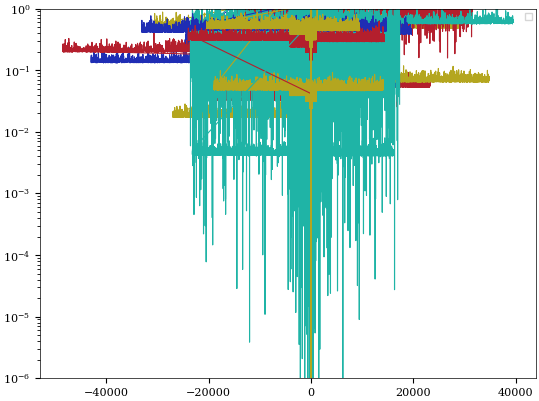

In [35]:
# Look at ACF for the same source
figure()
for e in v6_event_ids["R3"]:
    d = BBData.from_file(acf_tools.filename_from_event_id(e,version=7))
    l,eps = acf_tools.eps_vs_tau(d,iipol = 2,threshold = False,version=7,peak_match_short_lag=True) # combine polarizations
    r = np.abs(eps)**2
    #plot(d['lag_lossless'][:],d['acf_lossless'][0,0,:] - d['acf_lossless'][0,2,:],label = str(e) + 'e')
    #plot(d['lag_lossless'][:],d['acf_lossless'][1,0,:] - d['acf_lossless'][1,2,:],label = str(e) + 's')
    plot(l,r)
    #plot(repeat.lag[repeat.lag > 0],1 / repeat.r_f[repeat.lag > 0],label = repeat.name)
    yscale('log')
    #xlim(0,1e-1)
    ylim(1e-6,1)
    legend()


# Sensitivity to Bare Lenses
In the case that there are no scattering screens anywhere.

In [36]:
n_abcd = tau.dtau_dm(all_sightlines,
     m_range = m_range,
     lag_range = lag_range,
     min_rf = True,
     max_einstein_angle_global = np.inf,
     tau_scatt_global = 0 * u.s,
     d_sc_s = 0 * u.pc)   
        #title = f'{e}: DM_eg={dm_eg:0.1f}; z={z:0.3f};scatt={frb_source.tau_scatt:0.3E} sec; D_sc_s={d_sc_s_pc:0.1f}'
        #fig.suptitle(title)

Integrating 0/106
Using global value of max th_E=INF
Integrating 1/106
Using global value of max th_E=INF
Integrating 2/106
Using global value of max th_E=INF
Integrating 3/106
Using global value of max th_E=INF
Integrating 4/106
Using global value of max th_E=INF
Integrating 5/106
Using global value of max th_E=INF
Integrating 6/106
Using global value of max th_E=INF
Integrating 7/106
Using global value of max th_E=INF
Integrating 8/106
Using global value of max th_E=INF
Integrating 9/106
Using global value of max th_E=INF
Integrating 10/106
Using global value of max th_E=INF
Integrating 11/106
Using global value of max th_E=INF
Integrating 12/106
Using global value of max th_E=INF
Integrating 13/106
Using global value of max th_E=INF
Integrating 14/106
Using global value of max th_E=INF
Integrating 15/106
Using global value of max th_E=INF
Integrating 16/106
Using global value of max th_E=INF
Integrating 17/106
Using global value of max th_E=INF
Integrating 18/106
Using global value 

# Sensitivity to Unresolved Screens
Plot this as a function of average distance to screen

In [37]:
len(all_sightlines)

106

In [38]:
all_n_pc = []
for d_sc_s_pc in [0.1,1,10,100]:
    print('Starting calculation for',d_sc_s_pc)
    n_ac = tau.dtau_dm(all_sightlines,
         m_range = m_range,
         lag_range = lag_range,
         min_rf = True,
         max_einstein_angle_global = None,
         tau_scatt_global = np.inf * u.s,
         d_sc_s = d_sc_s_pc * u.pc,
         screen = 'hg',
         alpha_s = 0.5,
         alpha_l = -1
         )   
    all_n_pc.append(n_ac)
        #title = f'{e}: DM_eg={dm_eg:0.1f}; z={z:0.3f};scatt={frb_source.tau_scatt:0.3E} sec; D_sc_s={d_sc_s_pc:0.1f}'
        #fig.suptitle(title)

Starting calculation for 0.1
Integrating 0/106
Integrating 1/106
Integrating 2/106
Integrating 3/106
Integrating 4/106
Integrating 5/106
Integrating 6/106
Integrating 7/106
Integrating 8/106
Integrating 9/106
Integrating 10/106
Integrating 11/106
Integrating 12/106
Integrating 13/106
Integrating 14/106
Integrating 15/106
Integrating 16/106
Integrating 17/106
Integrating 18/106
Integrating 19/106
Integrating 20/106
Integrating 21/106
Integrating 22/106
Integrating 23/106
Integrating 24/106
Integrating 25/106
Integrating 26/106
Integrating 27/106
Integrating 28/106
Integrating 29/106
Integrating 30/106
Integrating 31/106
Integrating 32/106
Integrating 33/106
Integrating 34/106
Integrating 35/106
Integrating 36/106
Integrating 37/106
Integrating 38/106
Integrating 39/106
Integrating 40/106
Integrating 41/106
Integrating 42/106
Integrating 43/106
Integrating 44/106
Integrating 45/106
Integrating 46/106
Integrating 47/106
Integrating 48/106
Integrating 49/106
Integrating 50/106
Integrating 

In [39]:
n_ac = np.array(all_n_pc)

In [40]:
import plotting

In [41]:
n_abcd[...,dm < 1000].shape

(199, 49, 106, 1)

In [42]:
np.sum([b.dm > 500 for b in all_sightlines])

33

In [43]:
len(all_sightlines)

106

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: The following kwargs were not used by contour: 'orientation'
  if sys.path[0] == '':


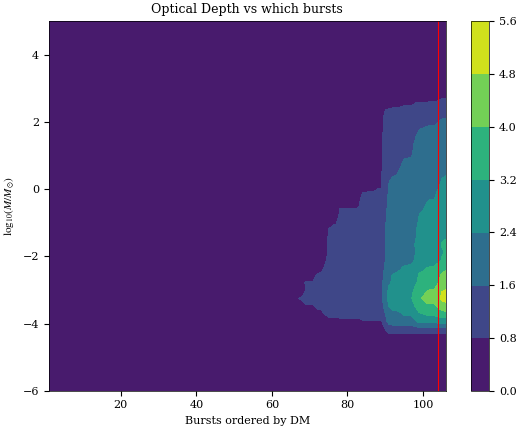

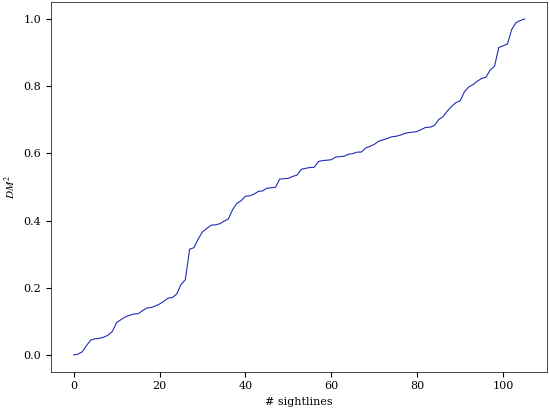

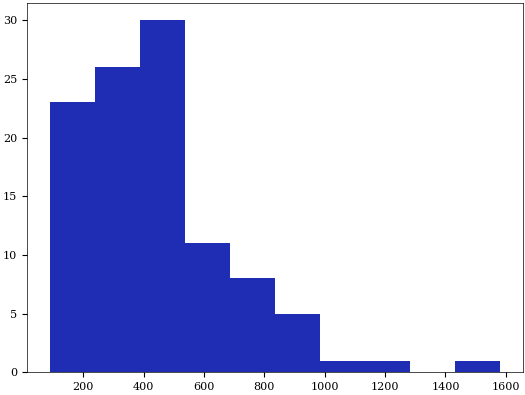

In [44]:
def plot_dm_vs_tau(n,dm, m_range):
    """
    Plots cumulative distribution of optical depth.
    n : np.array of shape (n_lag - 1, n_mass - 1, n_sightlines)
    dm : np.array of shape (n_sightlines)
    """
    figure()
    iisort = np.argsort(dm)
    cn = np.cumsum(np.sum(n[:,:,iisort],axis = 0),axis = -1)
    contourf(cn,orientation = 'horizontal',
             extent = [1,len(dm),
                       np.log10(np.min(m_range)),np.log10(np.max(m_range))],
             )
    colorbar()
    title('Optical Depth vs which bursts')
    axvline(x = 104, color = 'red')
    ylabel(r'$\log_{10}(M/M_{\odot})$')
    xlabel('Bursts ordered by DM')
    figure()
    dm2cum = np.cumsum(dm**2)
    plot(dm2cum / dm2cum[-1])
    ylabel('$DM^2$')
    xlabel('# sightlines')
    figure()
    hist(dm,bins = 10)
plot_dm_vs_tau(n_abcd,m_range = m_range,dm = np.array([b.dm for b in all_sightlines]))

In [49]:
n_abcd.shape

(199, 49, 106)

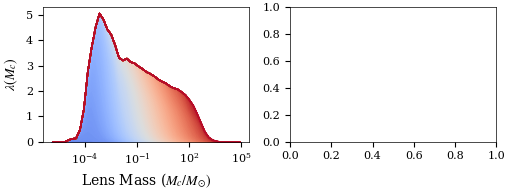

(<Figure size 585.114x175.534 with 2 Axes>,
 <AxesSubplot:xlabel='Lens Mass ($M_c/M_{\\odot})$', ylabel='$\\lambda(M_c)$'>)

In [50]:
f,ax = subplots(nrows = 1, ncols = 2, figsize = plotting.prd_size(fraction_of_textwidth=0.9,height_per_width = 0.3))
ax[0].set_ylabel(r'$\lambda(M_c)$',fontsize = 10)
import matplotlib as mpl
cmap = mpl.cm.coolwarm
normalize = mpl.colors.Normalize(vmin=np.log10(lag_range).min(), vmax=np.log10(lag_range).max())

plotting.plot_dtau_dm_vs_lag_shaded(np.sum(n_abcd,axis = -1),
                                    m_range,
                                    lag_range, 
                                    draw_colorbar = False, 
                                    fax = (f,ax[0]))

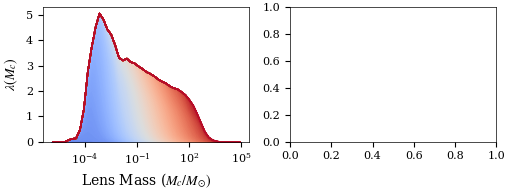

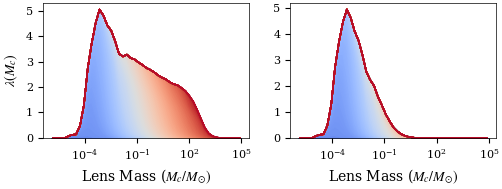

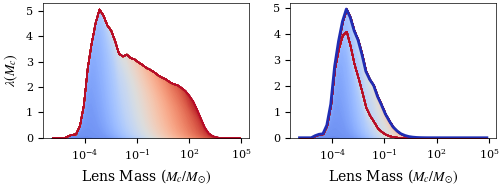

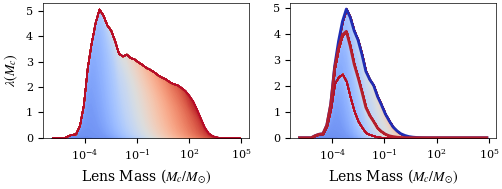

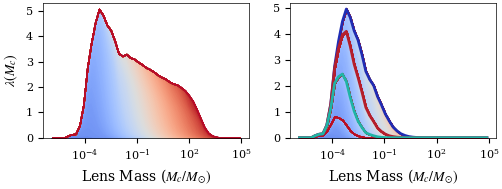

In [51]:
f,ax = subplots(nrows = 1, ncols = 2, figsize = plotting.prd_size(fraction_of_textwidth=0.9,height_per_width = 0.3))
ax[0].set_ylabel(r'$\lambda(M_c)$',fontsize = 10)
import matplotlib as mpl
cmap = mpl.cm.coolwarm
normalize = mpl.colors.Normalize(vmin=np.log10(lag_range).min(), vmax=np.log10(lag_range).max())

plotting.plot_dtau_dm_vs_lag_shaded(np.sum(n_abcd,axis = -1),
                                    m_range,
                                    lag_range, 
                                    draw_colorbar = False, 
                                    fax = (f,ax[0]))

for n,d_sc_s in zip(n_ac,[0.1,1,10,100]):
    plotting.plot_dtau_dm_vs_lag_shaded(np.sum(n,axis = -1),
                                        m_range,
                                        lag_range, 
                                        draw_colorbar = False, fax = (f,ax[1]))
    #ax.text(x = 1e-3, y = 4.5,s = ,fontsize = 14)
    ax[1].plot(geom_centers(m_range), np.sum(n,axis = (0,-1)), label = f'{d_sc_s} pc',lw = 2)
ax[0].plot(geom_centers(m_range), np.sum(n_abcd,axis = (0,-1)), label = f'No screens',lw = 2)
ax[0].set_xlim([1e-5,1e4])
ax[0].set_xticks([1e-4,1e-2,1e0,1e2,1e4])
ax[0].set_ylim([0,7])
ax[0].legend(loc='upper right')
    
ax[1].set_xlim([1e-5,1e4])
ax[1].set_ylim([0,7])

ax[1].legend(loc='upper right')
#tight_layout()
ax[1].set_yticklabels([])
ax[1].set_yticks([])
ax[1].set_xticks([1e-4,1e-2,1e0,1e2,1e4])

f.subplots_adjust(right=0.8,wspace = 0.02)
cbax = f.add_axes([0.81, 0.1, 0.02, 0.78])
cb = mpl.colorbar.ColorbarBase(cbax, cmap=cmap, norm=normalize, orientation='vertical')
cb.set_label(r'$\log_{10}$(lag / s)', rotation=90, fontsize = 10)
ax[0].grid(False)
ax[1].grid(False)
savefig('/home/calvin/Lensed-FRBs/plots/tau_combined_v7.png',dpi = 300)

# Table for Paper

# Bayesian and Frequentist constraints on $f_{dm}$

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: The following kwargs were not used by contour: 'aspect'
  # Remove the CWD from sys.path while we load stuff.


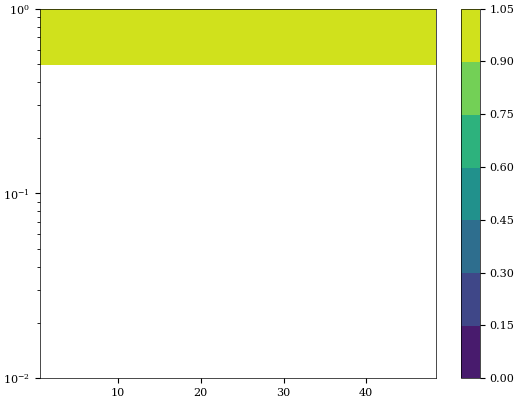

In [52]:
def n_exp_to_likelihood(n_vs_tau_vs_m,f_dm,detections):
    rate = np.sum(n_vs_tau_vs_m,axis = 0)
    if detections == 0:
        return np.exp(-rate[None,:] * f_dm[:,None])
    elif detections == 1:
        return (1 + rate[None,:] * f_dm[:,None]) * np.exp(-rate[None,:] * f_dm[:,None])
f_dm = np.logspace(-2,0,num = 100)

figure()
contourf(n_exp_to_likelihood(np.sum(n_abcd,axis = -1),f_dm,detections = 0),origin = 'lower',aspect = 'auto')
yscale('log')
ylim(1e-2,1e0)
colorbar()

In [63]:
def calculate_f(n,confidence=0.95,m_range=None,factor = 1, out_file='/home/calvin/PBHbounds/FRB.txt'):
    f_dm = np.minimum(-np.log(1-confidence) / (n * factor),100)
    m_centers = geom_centers(m_range)
    if out_file is not None:
        with open(out_file, 'w') as f:
            f.write(f'#{confidence*100}% confidence interval from FRB microlensing'+'\n')
            all_lines = [f'{mi:0.9f} {fi:0.5f}\n' for mi,fi in zip(m_centers, f_dm)]
            f.writelines(all_lines)
        for l in all_lines:
            print(l)
    return f_dm

calculate_f(np.sum(n_ac[0],axis = (0,-1)),m_range = m_range,
            out_file='/home/calvin/Lensed-FRBs/FRB_01pc.txt')
calculate_f(np.sum(n_ac[1],axis = (0,-1)),m_range = m_range,
            out_file='/home/calvin/Lensed-FRBs/FRB_1pc.txt')
calculate_f(np.sum(n_ac[2],axis = (0,-1)),m_range = m_range,
            out_file='/home/calvin/Lensed-FRBs/FRB_10pc.txt')
calculate_f(np.sum(n_ac[3],axis = (0,-1)),m_range = m_range,
            out_file='/home/calvin/Lensed-FRBs/FRB_100pc.txt')
calculate_f(np.sum(n_abcd,axis = (0,-1)),m_range = m_range,
            out_file='/home/calvin/Lensed-FRBs/FRB_no_screen.txt')
            
calculate_f(np.sum(n_ac[1],axis = (0,-1)),m_range = m_range,factor = 10,
            out_file='/home/calvin/Lensed-FRBs/FRB10_1pc.txt')

0.000001295 100.00000

0.000002171 100.00000

0.000003641 100.00000

0.000006105 100.00000

0.000010238 37.56128

0.000017167 22.30658

0.000028786 19.62924

0.000048270 6.15346

0.000080940 2.31158

0.000135723 1.08538

0.000227585 0.80365

0.000381621 0.66780

0.000639915 0.60297

0.001073031 0.64482

0.001799294 0.72556

0.003017115 0.79478

0.005059197 0.93208

0.008483429 1.16942

0.014225293 1.33447

0.023853440 1.48581

0.039998234 1.88618

0.067070356 2.36358

0.112465782 3.27301

0.188586328 4.63092

0.316227766 7.32878

0.530261134 11.57061

0.889159334 19.59131

1.490971657 33.70477

2.500110383 64.34344

4.192267435 100.00000

7.029732115 100.00000

11.787686348 100.00000

19.765980717 100.00000

33.144247495 100.00000

55.577365865 100.00000

93.193957623 100.00000

156.270697655 100.00000

262.039852886 100.00000

439.397056076 100.00000

736.795455966 100.00000

1235.482888257 100.00000

2071.698399895 100.00000

3473.892112083 100.00000

5825.136712469 100.00000

9767.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


array([1.00000000e+02, 1.00000000e+02, 1.00000000e+02, 1.00000000e+02,
       3.75701115e+00, 2.23103300e+00, 1.96374512e+00, 6.16183143e-01,
       2.32789278e-01, 1.11748141e-01, 8.66265991e-02, 7.54181465e-02,
       7.29371559e-02, 8.47981732e-02, 1.05525520e-01, 1.28719495e-01,
       1.69552984e-01, 2.56222603e-01, 3.49436041e-01, 4.79056207e-01,
       7.97918954e-01, 1.25431660e+00, 2.16484785e+00, 3.95188860e+00,
       6.89440452e+00, 1.43457990e+01, 3.22871655e+01, 7.93890389e+01,
       1.00000000e+02, 1.00000000e+02, 1.00000000e+02, 1.00000000e+02,
       1.00000000e+02, 1.00000000e+02, 1.00000000e+02, 1.00000000e+02,
       1.00000000e+02, 1.00000000e+02, 1.00000000e+02, 1.00000000e+02,
       1.00000000e+02, 1.00000000e+02, 1.00000000e+02, 1.00000000e+02,
       1.00000000e+02, 1.00000000e+02, 1.00000000e+02, 1.00000000e+02,
       1.00000000e+02])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


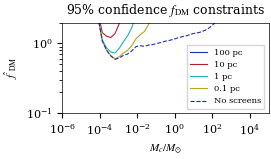

In [60]:
figure(figsize = plotting.prd_size(fraction_of_textwidth = 0.45))
#title('Frequentist Search v4 Constraints')
confidence = 0.95
title(f'{100 * confidence:.0f}% confidence ' + r'$f_{\rm DM}$ constraints')
plot(geom_centers(m_range),-np.log(1 - confidence) / np.sum(n_ac[3],axis = (0,-1)),label = f'100 pc')
plot(geom_centers(m_range),-np.log(1 - confidence) / np.sum(n_ac[2],axis = (0,-1)),label = f'10 pc')
plot(geom_centers(m_range),-np.log(1 - confidence) / np.sum(n_ac[1],axis = (0,-1)),label = f'1 pc')
plot(geom_centers(m_range),-np.log(1 - confidence) / np.sum(n_ac[0],axis = (0,-1)),label = f'0.1 pc')
plot(geom_centers(m_range),-np.log(1 - confidence) / np.sum(n_abcd,axis = (0,-1)),label = f'No screens',ls = '--')
ylim(1e-1,2)
xlim(m_range[0],m_range[-1])
yscale('log')
xscale('log')
ylabel(r'$\hat f_{\rm DM}$')
xlabel('$M_c/M_{\odot}$')
legend(loc = 'lower right')
tight_layout()
savefig('/home/calvin/Lensed-FRBs/plots/exclusion_v7.png',dpi = 300)

In [55]:
def p_f_given_n(n_vs_tau_vs_m,f_dm):
    n_vs_m = np.sum(n_vs_tau_vs_m,axis = (0,-1))
    norm = (1 - np.exp(-n_vs_m)) / n_vs_m
    return np.exp(-n_vs_m[None,:] * f_dm[:,None]) * norm[None,:]

def exceed_f(n_vs_tau_vs_m,eps = 0.05,F = 1):
    N = np.sum(n_vs_tau_vs_m,axis = (0,-1))
    #f_thresh = -np.log(eps * (1 - np.exp(-n_vs_m)) + np.exp(-n_vs_m)) / n_vs_m
    f_thresh = np.log((eps * (1 - np.exp(-F * N))) + np.exp(-F*N)) / (-N)
    return f_thresh

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


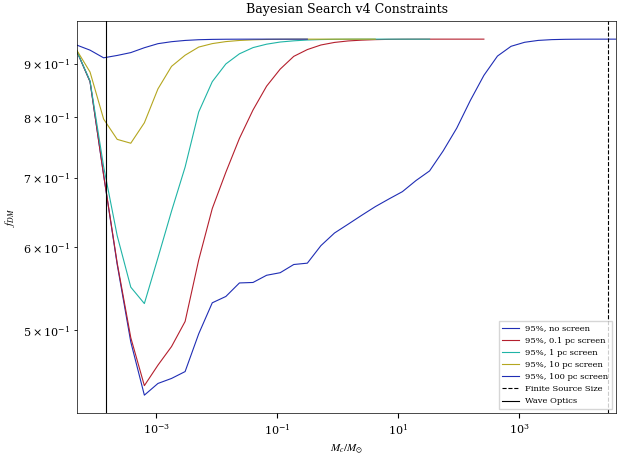

In [85]:
figure()
title('Bayesian Search v4 Constraints')
eps = 1 - 0.95
F = 1
#eps = 1 - 0.68
loglog(geom_centers(m_range),exceed_f(n_abcd, eps = eps,F = F),label = f'{(1 - eps) * 100:2.0f}%, no screen')
loglog(geom_centers(m_range),exceed_f(n_ac[0], eps = eps,F = F),label = f'{(1 - eps) * 100:2.0f}%, 0.1 pc screen')
loglog(geom_centers(m_range),exceed_f(n_ac[1], eps = eps,F = F),label = f'{(1 - eps) * 100:2.0f}%, 1 pc screen')
loglog(geom_centers(m_range),exceed_f(n_ac[2], eps = eps,F = F),label = f'{(1 - eps) * 100:2.0f}%, 10 pc screen')
loglog(geom_centers(m_range),exceed_f(n_ac[3], eps = eps,F = F),label = f'{(1 - eps) * 100:2.0f}%, 100 pc screen')
axvline(3e4,label = 'Finite Source Size',linestyle = 'dashed',color = 'black')
axvline(1.5e-4,label = 'Wave Optics',linestyle = 'solid',color = 'black')
xlim(5e-5,4e4)
yscale('log')
xscale('log')
ylabel(r'$f_{DM}$')
xlabel('$M_c/M_{\odot}$')
legend(loc = 'lower right')
tight_layout()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


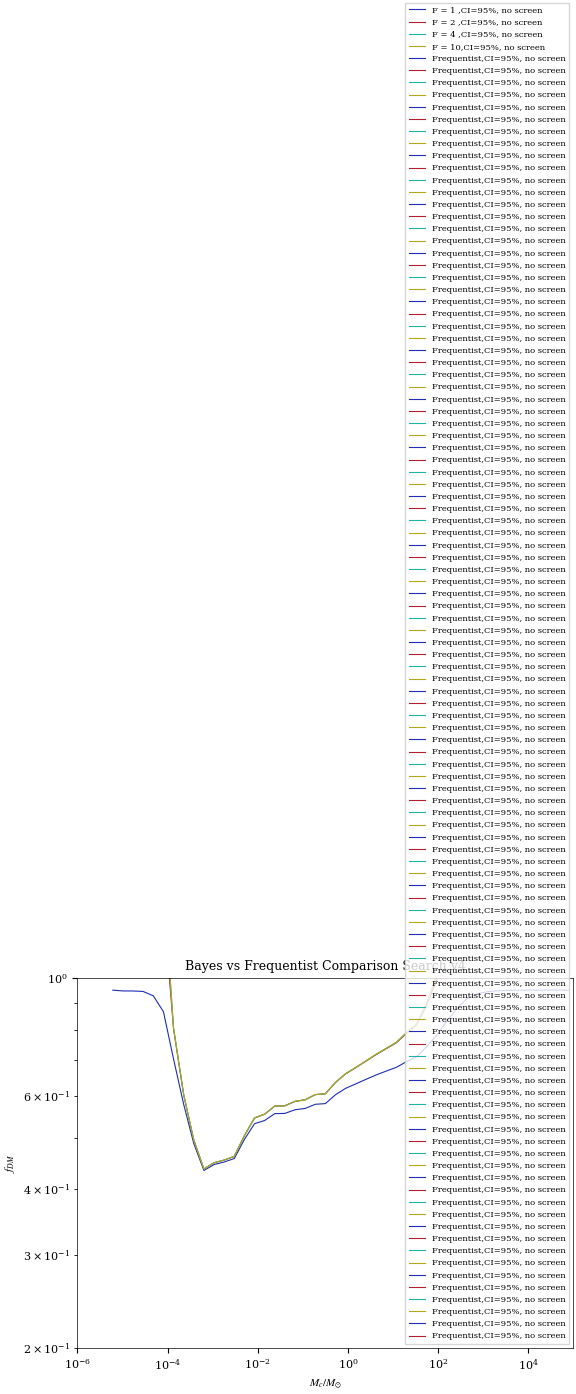

In [86]:
figure()
title('Bayes vs Frequentist Comparison Search v4')
eps = 1 - 0.95
#eps = 1 - 0.68
loglog(geom_centers(m_range),exceed_f(n_abcd, eps = eps,F = 1),label = f'F = 1 ,CI={(1 - eps) * 100:2.0f}%, no screen')
loglog(geom_centers(m_range),exceed_f(n_abcd, eps = eps,F = 2),label = f'F = 2 ,CI={(1 - eps) * 100:2.0f}%, no screen')
loglog(geom_centers(m_range),exceed_f(n_abcd, eps = eps,F = 4),label = f'F = 4 ,CI={(1 - eps) * 100:2.0f}%, no screen')
loglog(geom_centers(m_range),exceed_f(n_abcd, eps = eps,F = 10),label = f'F = 10,CI={(1 - eps) * 100:2.0f}%, no screen')
loglog(geom_centers(m_range),-np.log(eps) / np.sum(n_abcd,axis = 0),label = f'Frequentist,CI={(1 - eps) * 100:2.0f}%, no screen')



ylim(2e-1,1)
xlim(m_range[0],m_range[-1])
yscale('log')
xscale('log')
ylabel(r'$f_{DM}$')
xlabel('$M_c/M_{\odot}$')
legend(loc = 'lower right')
tight_layout()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


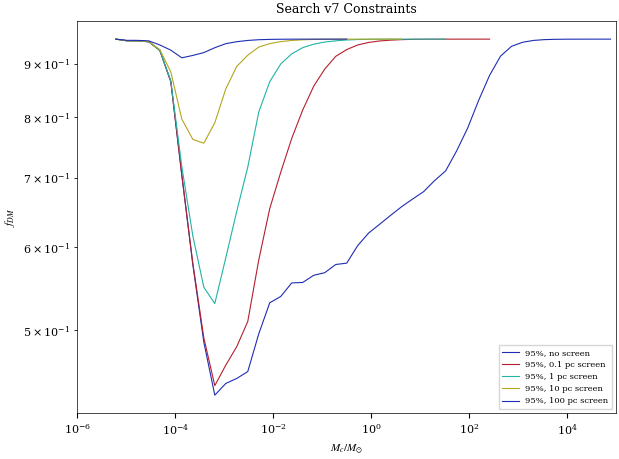

In [109]:
figure()
title('Search v7 Constraints')
eps = 1 - 0.95
F = 1
#eps = 1 - 0.68
loglog(geom_centers(m_range),exceed_f(n_abcd, eps = eps,F = F),label = f'{(1 - eps) * 100:2.0f}%, no screen')
loglog(geom_centers(m_range),exceed_f(n_ac[0], eps = eps,F = F),label = f'{(1 - eps) * 100:2.0f}%, 0.1 pc screen')
loglog(geom_centers(m_range),exceed_f(n_ac[1], eps = eps,F = F),label = f'{(1 - eps) * 100:2.0f}%, 1 pc screen')
loglog(geom_centers(m_range),exceed_f(n_ac[2], eps = eps,F = F),label = f'{(1 - eps) * 100:2.0f}%, 10 pc screen')
loglog(geom_centers(m_range),exceed_f(n_ac[3], eps = eps,F = F),label = f'{(1 - eps) * 100:2.0f}%, 100 pc screen')
#ylim(2e-1,1)
xlim(m_range[0],m_range[-1])
yscale('log')
xscale('log')
ylabel(r'$f_{DM}$')
xlabel('$M_c/M_{\odot}$')
legend(loc = 'lower right')
tight_layout()

In [74]:
f,ax = plotting.plot_dtau_dm_vs_lag_shaded(np.sum(n_abcd,axis = ,m_range,lag_range, draw_colorbar = True, fax = None)
    #ax.text(x = 1e-3, y = 4.5,s = ,fontsize = 14)
ax.plot(geom_centers(m_range), np.sum(n_abcd,axis = (0,-1)), label = f'No screens',lw = 2)
ax.set_xlim([1e-5,1e4])
ax.set_ylim([0,5])
ax.legend(loc='upper right')
ax.set_ylabel(r'$N_{exp}(M_c)$')
tight_layout()


AssertionError: Wrong number of dimensions!

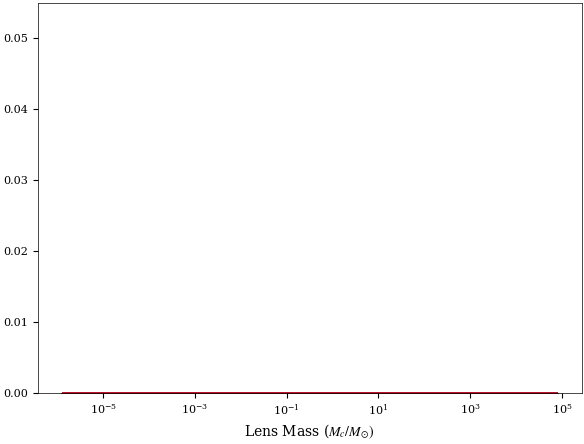

Text(0.5, 1.0, '$D_{Sc,S} = 1$ pc')

In [65]:
f,axs = plotting.plot_dtau_dm_vs_lag_shaded(n_ac[1],m_range,lag_range, draw_colorbar = False)
axs.set_xlim([1e-5,1e3])
axs.set_ylim([0,5])
axs.set_title(r'$D_{Sc,S} = 1$ pc')

In [42]:
f,axs = plot_dtau_dm_vs_lag_shaded(n_ac[2],m_range,lag_range, draw_colorbar = False)
axs.set_xlim([1e-5,1e3])
axs.set_ylim([0,5])
axs.set_title(r'$D_{Sc,S} = 10$ pc')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, '$D_{Sc,S} = 10$ pc')

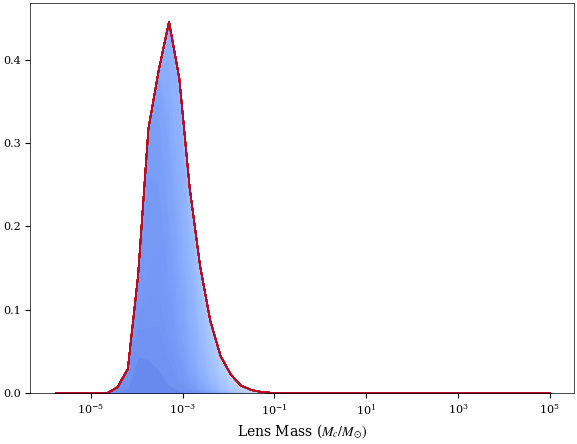

Text(0.5, 1.0, '$D_{Sc,S} = 100$ pc')

In [87]:
f,axs = plot_dtau_dm_vs_lag_shaded(n_ac[3],m_range,lag_range, draw_colorbar = False)
axs.set_xlim([1e-5,1e3])
axs.set_ylim([0,5])
axs.set_title(r'$D_{Sc,S} = 100$ pc')